# CSC 466 Fall 2023 Lab 2
### Sophia Chung, spchung@calpoly.edu
### Anagha Sikha, arsikha@calpoly.edu
#### For EXTENDED BASKET and Fantasy Bingo datasets, found best values of minSup and minConf, skyline frequent itemsets, and skyline association rules.

In [1]:
import pandas as pd
import numpy as np
import csv
from itertools import combinations
import matplotlib
import matplotlib.pyplot as plt

## Defining Functions

In [2]:
def read_vector(csv_file): # for reading in full binary vector format
    data = []
    with open(csv_file, mode='r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            row.extend(row[-1].split(','))
            del row[-2]
            data.append(row)
    data = pd.DataFrame(data).fillna(0)
    data = data.set_index(data.columns[0])
    return data

In [3]:
def support(T, itemset): # relative support
    count = 0
    for index, row in T.iterrows():
        flag = True
        for item in itemset:
            if row[item] != 1:
                flag = False
        if flag:
            count += 1
    return count/len(T)

In [4]:
def confidence(T, left, right):
    return support(T, left.union(right)) / support(T, left)

In [5]:
def candidateGen(F, k):
    C = []
    for f1, f2 in combinations(F, 2):
        if len(f1) == len(f2) == k:
            c = f1.union(f2)
            
            if len(c) == len(f1) + 1:
                flag = True
                for s in c:
                    copy = c.copy()
                    copy.remove(s)
                    if len(copy) == len(c) - 1:
                        if copy not in F:
                            flag = False
                if flag and (c not in C):
                    C.append(c)
    return C

In [6]:
def AprioriBakery(T, I, minSup):
    F = {} # dictionary to store frequent itemsets
    C = {} # dictionary to store candidate itemsets 
    all_FI = []
    all_sup = []
    
    F[1] = [{i} for i in I if support(T, {i}) >= minSup] # first pass
    all_FI += F[1]
    all_sup += [support(T, list(f)) for f in F[1]]
    
    k = 2
    while len(F[k-1]) > 1: # main loop
        C[k] = candidateGen(F[k-1], k-1)
        count = {} # dictionary to store supports
        for i, c in enumerate(C[k]):
            count[i] = support(T, c)
            
        F[k] = []
        for i, c in enumerate(C[k]): # check support >= minSup
            if count[i] >= minSup:
                F[k].append(c)
                all_sup.append(count[i])
        all_FI += F[k]
        k += 1
    
    # check if skyline
    skyline_sets = []
    skyline_sups = []
    for k, set1 in enumerate(all_FI):
        is_skyline = True
        for set2 in all_FI:
            if set1 != set2 and set1.issubset(set2):
                is_skyline = False
        if is_skyline:
            skyline_sets.append(set1)
            skyline_sups.append(all_sup[k])
    
    # prettify
    print('Number of Skyline Frequent Itemsets: ' + str(len(skyline_sets)))
    for num, itemset in enumerate(skyline_sets):
        converted = []
        for item in list(itemset):
            converted.append(' '.join(goods.iloc[item, 0:2]))
        str_converted = ', '.join(converted)
        print('Itemset ' + str(num + 1) + ': ' + str_converted + '     [sup=' + str(round(skyline_sups[num]*100, 5)) + ']')
    return skyline_sets

In [7]:
def genRulesBakery(T, skyline, minConf):
    H1 = []
    for f in skyline:
        if len(f) >= 2:
            for s in list(f):
                conf = confidence(T, f - {s}, {s})
                if conf >= minConf:
                    sup = support(T, f)
                    H1.append([f - {s}, {s}, conf, sup])
                    
    # prettify
    print('\n')
    print('Number of Skyline Association Rules: ' + str(len(H1)))
    for num, rule in enumerate(H1):
        left = list(rule[0])
        for index, item in enumerate(left):
            left[index] = ' '.join(goods.iloc[item, 0:2])
        str_left = ', '.join(left)
        right = list(rule[1])
        right[0] = ' '.join(goods.iloc[right[0], 0:2])
        sup = str(round(rule[3]*100, 5))
        conf = str(round(rule[2]*100, 5))
        print('Rule ' + str(num + 1) + ':     ' + str_left + ' --> ' + right[0] + '     [sup=' + sup + ', conf=' + conf + ']')

## EXTENDED BAKERY 1000

In [8]:
# need this goods list for all bakery datasets
goods = pd.read_csv('goods.csv', index_col=[0])
goods.columns = ['Flavor', 'Food', 'Price', 'Type']
goods[['Flavor', 'Food', 'Type']] = goods[['Flavor', 'Food', 'Type']].applymap(lambda x: x.strip("'"))

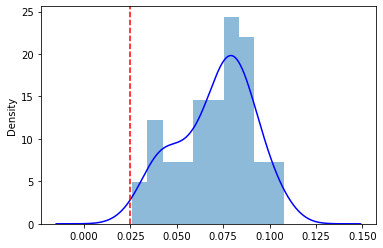

In [9]:
df_1000 = pd.read_csv('1000-out2.csv', header=None, index_col=[0])
df_1000.columns = [int(col) - 1 for col in df_1000.columns]

fig, ax = plt.subplots()
mean_density = df_1000.mean()
mean_density.hist(density=True, alpha=0.5)
mean_density.plot(kind='kde', color='blue')
ax.axvline(x=0.025, color='red', linestyle='--')

In [10]:
T = df_1000
I = list(df_1000.columns)
minSup = 0.025
minConf = 0.75

In [11]:
skyline = AprioriBakery(T, I, minSup)
genRulesBakery(T, skyline, minConf)

Number of Skyline Frequent Itemsets: 32
Itemset 1: Chocolate Eclair     [sup=3.4]
Itemset 2: Vanilla Eclair     [sup=3.7]
Itemset 3: Almond Tart     [sup=4.1]
Itemset 4: Apricot Tart     [sup=5.6]
Itemset 5: Pecan Tart     [sup=4.0]
Itemset 6: Ganache Cookie     [sup=4.4]
Itemset 7: Chocolate Meringue     [sup=3.8]
Itemset 8: Vanilla Meringue     [sup=4.7]
Itemset 9: Walnut Cookie     [sup=6.1]
Itemset 10: Almond Croissant     [sup=4.9]
Itemset 11: Chocolate Croissant     [sup=4.2]
Itemset 12: Almond Bear Claw     [sup=2.6]
Itemset 13: Blueberry Danish     [sup=5.5]
Itemset 14: Green Tea     [sup=6.2]
Itemset 15: Single Espresso     [sup=5.9]
Itemset 16: Lemon Cake, Lemon Tart     [sup=4.0]
Itemset 17: Napoleon Cake, Strawberry Cake     [sup=4.9]
Itemset 18: Truffle Cake, Gongolais Cookie     [sup=5.8]
Itemset 19: Blackberry Tart, Coffee Eclair     [sup=3.1]
Itemset 20: Hot Coffee, Coffee Eclair     [sup=2.6]
Itemset 21: Apple Pie, Hot Coffee     [sup=2.9]
Itemset 22: Bottled Water, Be

## EXTENDED BAKERY 5000

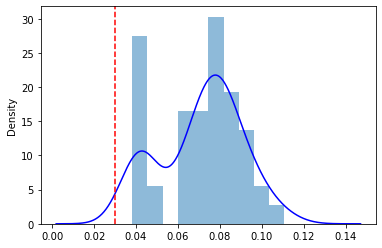

In [12]:
df_5000 = pd.read_csv('5000-out2.csv', header=None, index_col=[0])
df_5000.columns = [int(col) - 1 for col in df_5000.columns]

fig, ax = plt.subplots()
mean_density = df_5000.mean()
mean_density.hist(density=True, alpha=0.5)
mean_density.plot(kind='kde', color='blue')
ax.axvline(x=0.03, color='red', linestyle='--')

In [13]:
T = df_5000
I = list(df_5000.columns)
minSup = 0.03
minConf = 0.49

In [14]:
skyline = AprioriBakery(T, I, minSup)
genRulesBakery(T, skyline, minConf)

Number of Skyline Frequent Itemsets: 35
Itemset 1: Chocolate Eclair     [sup=3.82]
Itemset 2: Vanilla Eclair     [sup=4.6]
Itemset 3: Almond Tart     [sup=3.86]
Itemset 4: Apricot Tart     [sup=4.22]
Itemset 5: Pecan Tart     [sup=4.44]
Itemset 6: Ganache Cookie     [sup=3.88]
Itemset 7: Raspberry Cookie     [sup=6.4]
Itemset 8: Lemon Cookie     [sup=6.42]
Itemset 9: Chocolate Meringue     [sup=4.52]
Itemset 10: Vanilla Meringue     [sup=3.98]
Itemset 11: Walnut Cookie     [sup=7.06]
Itemset 12: Almond Croissant     [sup=4.56]
Itemset 13: Chocolate Croissant     [sup=4.32]
Itemset 14: Almond Bear Claw     [sup=4.28]
Itemset 15: Blueberry Danish     [sup=4.0]
Itemset 16: Lemon Lemonade     [sup=6.48]
Itemset 17: Raspberry Lemonade     [sup=6.78]
Itemset 18: Green Tea     [sup=6.2]
Itemset 19: Cherry Soda     [sup=6.7]
Itemset 20: Lemon Cake, Lemon Tart     [sup=3.36]
Itemset 21: Napoleon Cake, Strawberry Cake     [sup=4.22]
Itemset 22: Truffle Cake, Gongolais Cookie     [sup=4.72]
Items

## EXTENDED BAKERY 20000

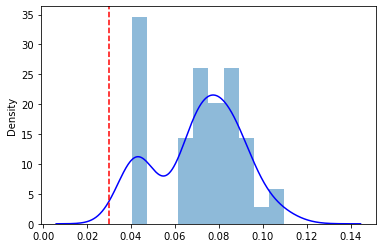

In [15]:
df_20000 = pd.read_csv('20000-out2.csv', header=None, index_col=[0])
df_20000.columns = [int(col) - 1 for col in df_20000.columns]

fig, ax = plt.subplots()
mean_density = df_20000.mean()
mean_density.hist(density=True, alpha=0.5)
mean_density.plot(kind='kde', color='blue')
x_value = 0.03
ax.axvline(x=0.03, color='red', linestyle='--')

In [16]:
T = df_20000
I = list(df_20000.columns)
minSup = 0.03
minConf = 0.49

In [17]:
skyline = AprioriBakery(T, I, minSup)
genRulesBakery(T, skyline, minConf)

Number of Skyline Frequent Itemsets: 39
Itemset 1: Chocolate Eclair     [sup=4.26]
Itemset 2: Vanilla Eclair     [sup=4.27]
Itemset 3: Almond Tart     [sup=4.055]
Itemset 4: Apple Tart     [sup=6.925]
Itemset 5: Apricot Tart     [sup=4.275]
Itemset 6: Pecan Tart     [sup=4.155]
Itemset 7: Ganache Cookie     [sup=4.33]
Itemset 8: Raspberry Cookie     [sup=6.945]
Itemset 9: Lemon Cookie     [sup=6.825]
Itemset 10: Chocolate Meringue     [sup=4.45]
Itemset 11: Vanilla Meringue     [sup=4.24]
Itemset 12: Almond Croissant     [sup=4.205]
Itemset 13: Apple Croissant     [sup=7.1]
Itemset 14: Chocolate Croissant     [sup=4.46]
Itemset 15: Apple Danish     [sup=6.755]
Itemset 16: Almond Bear Claw     [sup=4.425]
Itemset 17: Blueberry Danish     [sup=4.115]
Itemset 18: Lemon Lemonade     [sup=6.655]
Itemset 19: Raspberry Lemonade     [sup=6.845]
Itemset 20: Green Tea     [sup=6.215]
Itemset 21: Cherry Soda     [sup=6.53]
Itemset 22: Lemon Cake, Lemon Tart     [sup=3.7]
Itemset 23: Napoleon Cake

## EXTENDED BAKERY 75000

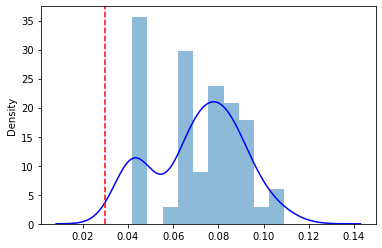

In [18]:
df_75000 = pd.read_csv('75000-out2.csv', header=None, index_col=[0])
df_75000.columns = [int(col) - 1 for col in df_75000.columns]

fig, ax = plt.subplots()
mean_density = df_75000.mean()
mean_density.hist(density=True, alpha=0.5)
mean_density.plot(kind='kde', color='blue')
x_value = 0.03
ax.axvline(x=0.03, color='red', linestyle='--')

In [19]:
T = df_75000
I = list(df_75000.columns)
minSup = 0.03
minConf = 0.49

In [20]:
skyline = AprioriBakery(T, I, minSup)

Number of Skyline Frequent Itemsets: 38
Itemset 1: Chocolate Eclair     [sup=4.23733]
Itemset 2: Vanilla Eclair     [sup=4.252]
Itemset 3: Almond Tart     [sup=4.204]
Itemset 4: Apple Tart     [sup=6.82267]
Itemset 5: Apricot Tart     [sup=4.236]
Itemset 6: Pecan Tart     [sup=4.33733]
Itemset 7: Ganache Cookie     [sup=4.324]
Itemset 8: Raspberry Cookie     [sup=6.764]
Itemset 9: Lemon Cookie     [sup=6.80133]
Itemset 10: Chocolate Meringue     [sup=4.19333]
Itemset 11: Vanilla Meringue     [sup=4.23867]
Itemset 12: Walnut Cookie     [sup=6.78533]
Itemset 13: Almond Croissant     [sup=4.27333]
Itemset 14: Apple Croissant     [sup=6.72933]
Itemset 15: Chocolate Croissant     [sup=4.324]
Itemset 16: Apple Danish     [sup=6.76933]
Itemset 17: Almond Bear Claw     [sup=4.244]
Itemset 18: Blueberry Danish     [sup=4.40933]
Itemset 19: Lemon Lemonade     [sup=6.824]
Itemset 20: Raspberry Lemonade     [sup=6.77467]
Itemset 21: Green Tea     [sup=6.24667]
Itemset 22: Cherry Soda     [sup=6.19

In [21]:
genRulesBakery(T, skyline, minConf)



Number of Skyline Association Rules: 18
Rule 1:     Napoleon Cake --> Strawberry Cake     [sup=4.31467, conf=52.14309]
Rule 2:     Truffle Cake --> Gongolais Cookie     [sup=4.392, conf=53.40467]
Rule 3:     Bottled Water --> Berry Tart     [sup=3.78, conf=50.26596]
Rule 4:     Tuile Cookie --> Marzipan Cookie     [sup=5.092, conf=50.54262]
Rule 5:     Marzipan Cookie --> Tuile Cookie     [sup=5.092, conf=56.72063]
Rule 6:     Cheese Croissant --> Orange Juice     [sup=4.30667, conf=52.38404]
Rule 7:     Casino Cake, Chocolate Coffee --> Chocolate Cake     [sup=3.33867, conf=94.74082]
Rule 8:     Chocolate Cake, Chocolate Coffee --> Casino Cake     [sup=3.33867, conf=75.80987]
Rule 9:     Chocolate Cake, Casino Cake --> Chocolate Coffee     [sup=3.33867, conf=93.95872]
Rule 10:     Cherry Tart, Opera Cake --> Apricot Danish     [sup=4.11067, conf=94.77405]
Rule 11:     Opera Cake, Apricot Danish --> Cherry Tart     [sup=4.11067, conf=95.53765]
Rule 12:     Cherry Tart, Apricot Danish

## Fantasy Bingo

In [22]:
def AprioriBingo(T, I, minSup):
    F = {} # dictionary to store frequent itemsets
    C = {} # dictionary to store candidate itemsets
    all_FI = []
    all_sup = []
    
    F[1] = [{i} for i in I if support(T, {i}) >= minSup] # first pass
    all_FI += F[1]
    all_sup += [support(T, list(f)) for f in F[1]]
    
    k = 2
    while len(F[k-1]) > 1: # main loop
        C[k] = candidateGen(F[k-1], k-1)
        count = {} # dictionary to store supports
        for i, c in enumerate(C[k]):
            count[i] = support(T, c)
            
        F[k] = []
        for i, c in enumerate(C[k]): # check support >= minSup
            if count[i] >= minSup:
                F[k].append(c)
                all_sup.append(count[i])
        all_FI += F[k]
        k += 1
    
    # check if skyline
    skyline_sets = []
    skyline_sups = []
    for k, set1 in enumerate(all_FI):
        is_skyline = True
        for set2 in all_FI:
            if set1 != set2 and set1.issubset(set2):
                is_skyline = False
        if is_skyline:
            skyline_sets.append(set1)
            skyline_sups.append(all_sup[k])
            
    # prettify
    print('Number of Skyline Frequent Itemsets: ' + str(len(skyline_sets)))
    for num, itemset in enumerate(skyline_sets):
        converted = []
        for author in list(itemset):
            converted.append(''.join(authors.iloc[author - 1, 1]))
        str_converted = ', '.join(converted)
        print('Itemset ' + str(num + 1) + ': ' + str_converted + '     [sup=' + str(round(skyline_sups[num]*100, 5)) + ']')
    return skyline_sets

In [23]:
def genRulesBingo(T, skyline, minConf):
    H1 = []
    for f in skyline:
        if len(f) >= 2:
            for s in list(f):
                conf = confidence(T, f - {s}, {s})
                if conf >= minConf:
                    sup = support(T, f)
                    H1.append([f - {s}, {s}, conf, sup])

    # prettify
    print('\n')
    print('Number of Skyline Association Rules: ' + str(len(H1)))
    for num, rule in enumerate(H1):
        left = list(rule[0])
        for index, author in enumerate(left):
            left[index] = authors.iloc[author - 1, 1]
        str_left = ', '.join(left)
        right = list(rule[1])
        right[0] = authors.iloc[right[0] - 1, 1]
        conf = str(round(rule[2]*100, 5))
        sup = str(round(rule[3]*100, 5))
        print('Rule ' + str(num + 1) + ':     ' + str_left + ' --> ' + right[0] + '     [sup=' + sup + ', conf=' + conf + ']')

In [24]:
authors = pd.read_csv('authorlist.psv.txt', sep='|', header=None)
authors.columns = ['Id', 'Name']
baskets = read_vector('bingoBaskets.csv') # sparse vector format

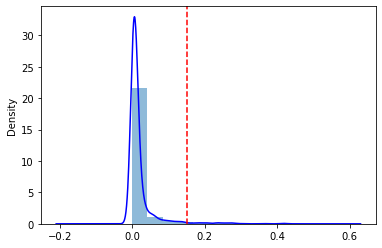

In [25]:
# convert to full binary vector format
T = pd.DataFrame(index=range(len(baskets)), columns=range(1, len(authors) + 2))
for index, row in baskets.iterrows():
    for val in row:
        if val != 0:
            T.iloc[int(index), int(val)] = 1
T = T.fillna(0)
T.columns = [int(col) - 1 for col in T.columns]

fig, ax = plt.subplots()
mean_density = T.mean()
mean_density.hist(density=True, alpha=0.5)
mean_density.plot(kind='kde', color='blue')
ax.axvline(x=0.15, color='red', linestyle='--')

In [26]:
I = list(T.columns)[1:]
minSup = 0.15
minConf = 0.4

In [27]:
skyline = AprioriBingo(T, I, minSup)
genRulesBingo(T, skyline, minConf)

Number of Skyline Frequent Itemsets: 29
Itemset 1:  *N/A     [sup=18.107]
Itemset 2:  Aaron, Rachel / Bach, Rachel     [sup=23.45679]
Itemset 3:  Abercrombie, Joe     [sup=18.107]
Itemset 4:  Addison, Katherine / Monette, Sarah     [sup=24.69136]
Itemset 5:  Arden, Katherine     [sup=20.57613]
Itemset 6:  Ball, Krista D. / Ball, K.     [sup=20.16461]
Itemset 7:  Brennan, Marie     [sup=27.57202]
Itemset 8:  Butcher, Jim     [sup=16.04938]
Itemset 9:  Chambers, Becky     [sup=20.57613]
Itemset 10:  Eames, Nicholas     [sup=26.33745]
Itemset 11:  Gladstone, Max     [sup=18.107]
Itemset 12:  Hobb, Robin / Lindholm, Megan     [sup=28.39506]
Itemset 13:  King, Stephen     [sup=18.107]
Itemset 14:  Le Guin, Ursula K.     [sup=23.45679]
Itemset 15:  Lynch, Scott     [sup=19.75309]
Itemset 16:  McClellan, Brian     [sup=17.28395]
Itemset 17:  Mieville, China     [sup=25.92593]
Itemset 18:  Novik, Naomi     [sup=26.33745]
Itemset 19:  Rowe, Andrew     [sup=24.27984]
Itemset 20:  Schafer, Courtn